## Importing required libraries

In [127]:
import sys
sys.path.append('/home/aistudio/external-libraries')

import jax
import jax.numpy as jnp
import jax.random as random

import time
import math
import numpy as np
import pandas as pd

import optax
import jaxopt
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.gridspec as gridspec
from typing import Tuple

import scipy.io
from scipy.stats import qmc
from scipy.special import factorial
jax.config.update("jax_enable_x64", True)

font_path = '/home/aistudio/Times_New_Roman.ttf'
prop = font_manager.FontProperties(fname=font_path)

## Config for solving DDE

In [128]:
# config = {
#     "real_lag": 0.5,
#     "init_lag": 0.,
#     "noise_level": 0.1,
#     "tmin": 0.,
#     "tmax": 10.,
#     "conds": [0., 1.],
#     "initial_key": 0,
#     "netLayers": [1, 20, 40, 20, 1],
#     "record_info": True,
#     "gap": 100,
#     "N_f": 5000,
#     "step_epochs": [2000, 3000],
#     "initial_lr" : 1e-3,
#     "cosine_decay_steps": 1000,
#     "cosine_alpha": 0.01,
#     "given_data_root_path": "/home/aistudio/DDE_2rd_revision/data/ex4.2.1",
#     "result_save_path": "/home/aistudio/DDE_2rd_revision/result/ex4.2.1"
# }

In [ ]:
# Retrieve the variable 'config' from IPython's storage space
%store -r config

## Defining the Delay Differential Equation
Let $ y'(t) = -y(t-\tau) $, for $ t \leq 0 $, where $ y(t) = 1 $.

In [129]:
# Define the differential equation
def DDE(t, u, lag):
    # Define u'(t)
    u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)))(t)

    # Define the right-hand side of the DDE
    rhs = -jnp.where(t > lag, u(t - lag), 1)
    return u_t(t) - rhs

## Construct the DNNs and initialize parameters

In [130]:
# Define the DNNs model
def DNNs(params, x):
    for w, b in params[:-2]:
        x = jnp.dot(x, w) + b
        x = jnp.tanh(x)

    w, b = params[-2]
    x = jnp.dot(x, w) + b
    return x

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    xavier_stddev = jnp.sqrt(2.0 / (m + n))

    w_key, b_key = jax.random.split(key)

    weights = xavier_stddev * jax.random.truncated_normal(
        w_key, lower=-2.0, upper=2.0, shape=(m, n)
    )
    biases = jnp.zeros((n,))

    return weights, biases

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Define the loss function

In [131]:
@jax.jit
def loss_fun1(params, inPoints, conds, init_data):
    lag = params[-1]
    t_c = inPoints[:, [0]]
    ufunc = lambda t: DNNs(params, t)

    # Compute the loss from the differential equation
    loss_f = jnp.mean(DDE(t_c, ufunc, lag)**2)

    # Compute the loss from the initial conditions
    t_0, u_0 = conds[:, [0]], conds[:, [1]]
    loss_init = jnp.mean((ufunc(t_0) - u_0)**2)

    # Compute the loss from the gaven data
    t_g, u_g = init_data[:,0].reshape(-1,1), init_data[:,1].reshape(-1,1)
    loss_g = jnp.mean((u_g - ufunc(t_g))**2)

    # Compute the sum of loss from all components
    loss_sum = loss_f + loss_g + loss_init

    # Gather all loss terms
    all_losses = jnp.array([loss_f, loss_g, loss_init])
    total_loss = jnp.sum(all_losses)

    # Dynamic weights
    weights = all_losses / total_loss

    # Weighted total loss
    loss_weighted = jnp.sum(all_losses * weights)

    return loss_weighted, all_losses


@jax.jit
def loss_fun2(params, inPoints, conds, init_data, initial_weights):
    lag = params[-1]
    t_c = inPoints[:, [0]]
    ufunc = lambda t: DNNs(params, t)

    # Compute the loss from the differential equation
    loss_f = jnp.mean(DDE(t_c, ufunc, lag)**2)

    # Compute the loss from the initial conditions
    t_0, u_0 = conds[:, [0]], conds[:, [1]]
    loss_init = jnp.mean((ufunc(t_0) - u_0)**2)

    # Compute the loss from the gaven data
    t_g, u_g = init_data[:,0].reshape(-1,1), init_data[:,1].reshape(-1,1)
    loss_g = jnp.mean((u_g - ufunc(t_g))**2)

    # Gather all loss terms
    all_losses = jnp.array([loss_f, loss_g, loss_init])

    # Weighted total loss
    loss_weighted = jnp.sum(all_losses * initial_weights)

    return loss_weighted, all_losses

## Two-step neural network training

In [132]:
# First Step：Adam Optimizer
def train_adam(params, inPoints, conds, init_data, record_info, num_epochs, start_epoch=0, log_interval=100, print_interval=1000):
    phase_epochs = []
    phase_losses = []
    phase_loss_terms = []
    phase_lag = []

    scheduler = optax.cosine_decay_schedule(
        init_value=config['initial_lr'],
        decay_steps=config['cosine_decay_steps'],
        alpha=config['cosine_alpha']
    )
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    @jax.jit
    def update_adam(params, inPoints, conds, init_data, opt_state):
        (loss, all_losses), grads = jax.value_and_grad(loss_fun1, has_aux=True)(
            params, inPoints, conds, init_data
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, (loss, all_losses)

    if record_info:
        for epoch in range(num_epochs):
            params, opt_state, (loss, all_losses) = update_adam(
                params, inPoints, conds, init_data, opt_state
            )
            current_epoch = start_epoch + epoch

            if record_info and current_epoch % log_interval == 0:
                phase_epochs.append(current_epoch)
                phase_losses.append(loss)
                phase_loss_terms.append(all_losses)
                phase_lag.append(params[-1])

            if record_info and current_epoch % print_interval == 0:
                print(f"Epoch {current_epoch}, Total Loss: {loss:.3e}")
        
        return params, phase_epochs, phase_losses, phase_loss_terms, phase_lag, all_losses
    else:
        now_epoch = 0
        while now_epoch < num_epochs:
            params, opt_state, (loss, all_losses) = update_adam(
                params, inPoints, conds, init_data, opt_state
            )
            now_epoch += 1
        return params, None, None, None, None, all_losses


# Second Step：L-BFGS Optimizer
def train_lbfgs(params, inPoints, conds, init_data, initial_weights,
                record_info, num_epochs=10000, gap=100, start_epoch=0):

    phase_epochs = []
    phase_losses = []
    phase_loss_terms = []
    phase_lag = []

    current_params = params

    if record_info:
        solver = jaxopt.BFGS(
            fun=loss_fun2,
            tol=1e-16,
            maxiter=gap,
            has_aux=True,
            verbose=False
        )

        for epoch in range(start_epoch, start_epoch + num_epochs + 1, gap):
            sol = solver.run(current_params, inPoints, conds, init_data, initial_weights)
            current_params = sol.params
            loss, all_losses = sol.state.value, sol.state.aux

            phase_losses.append(loss)
            phase_loss_terms.append(all_losses)
            phase_epochs.append(epoch + gap)
            phase_lag.append(current_params[-1])

            # print(f"Epoch {epoch+gap}, Total Loss: {loss:.3e}")
            print(f"Epoch {epoch+gap}, Total Loss: {loss:.3e}, Lag: {phase_lag[-1]}")

        return current_params, phase_epochs, phase_losses, phase_loss_terms, phase_lag, all_losses

    else:
        solver = jaxopt.BFGS(
            fun=loss_fun2,
            tol=1e-16,
            maxiter=num_epochs,
            has_aux=True,
            verbose=False
        )
        sol = solver.run(current_params, inPoints, conds, init_data, initial_weights)
        current_params = sol.params
        return current_params, None, None, None, None, sol.state.aux

def get_fixed_weights(loss_jnp):
    losses = jax.lax.stop_gradient(loss_jnp)
    return losses / jnp.sum(losses)

## Boundary Condition Initialization and Random Sampling Strategy for Solving DDE

In [133]:
lag = config["real_lag"]

# conds represents the initial condition y(0) = 1
conds = jnp.array(config['conds']).reshape(1,-1)

# Initial key for random number generator
ik = config['initial_key']

# Number of internal random points
N_f = config['N_f']

# Range for sampling points
tmin, tmax = config['tmin'], config['tmax']

# Generate random points within the specified range
jaxKey = jax.random.PRNGKey(ik)

sampler = qmc.LatinHypercube(d=1)

sample = sampler.random(n=N_f)
Inn_T = qmc.scale(sample, tmin, tmax)
inPoints = jnp.array(Inn_T)

# Load the dataset with the given real lag value
given_data_path = os.path.join(config['given_data_root_path'], f"DDE23_ex4.2.1_tau_{lag}.csv")
given_data = pd.read_csv(given_data_path)

t_g_data = jnp.array(given_data.iloc[:, [0]].to_numpy())
y_g_data = jnp.array(given_data.iloc[:, [1]].to_numpy())

noise = config["noise_level"] * jax.random.normal(jaxKey, shape=t_g_data.shape)
y_g_noise_data = y_g_data*(1+noise)

# Extract given data points from the dataset and convert to JAX-compatible numpy array
init_data = jnp.column_stack((t_g_data, y_g_noise_data))

# Network architecture
netLayers = config['netLayers']

# Initialize network parameters
params = init_network_params(netLayers, jaxKey)

# Append the parameter for the inverse problem (time delay 'lag') to the network parameters
lag_params = jnp.array(config['init_lag'], dtype=jnp.float64)
params.append(lag_params)

## Training

In [134]:
epoch_history = []
loss_history = []
loss_items_hostory = []
lag_history = []

adam_epochs = config["step_epochs"][0]
lbfgs_epochs = config["step_epochs"][1]
stage1_epochs = adam_epochs + lbfgs_epochs

record_info = config['record_info']
gap = config['gap']

start_time_nn = time.time()

# 第一阶段adam训练
params, hist1_epoch, hist1_loss, hist1_loss_items, hist1_lag, loss_components = train_adam(params, inPoints, conds, init_data, record_info, adam_epochs, start_epoch=0, log_interval=50, print_interval=1000)

initial_weights = get_fixed_weights(loss_components)

# 第二阶段lbfgs训练
params, hist2_epoch, hist2_loss, hist2_loss_items, hist2_lag, _ = train_lbfgs(params, inPoints, conds, init_data, initial_weights, record_info, num_epochs=lbfgs_epochs, gap=gap, start_epoch=adam_epochs)

end_time_nn = time.time()
time_nn = end_time_nn - start_time_nn

# 合并训练记录
if record_info:
    epoch_history.extend(hist1_epoch + hist2_epoch)
    loss_history.extend(hist1_loss + hist2_loss)
    loss_items_hostory.extend(hist1_loss_items + hist2_loss_items)
    loss_items_history_array = jnp.stack(loss_items_hostory)
    lag_history.extend(hist1_lag + hist2_lag)


Epoch 0, Total Loss: 7.792e-01
Epoch 1000, Total Loss: 2.855e-04
Epoch 2025, Total Loss: 8.548e-05, Lag: 0.45271690950469573
Epoch 2050, Total Loss: 5.072e-05, Lag: 0.47480416894393385
Epoch 2075, Total Loss: 3.929e-05, Lag: 0.47966945285146756
Epoch 2100, Total Loss: 3.412e-05, Lag: 0.48436335482170034
Epoch 2125, Total Loss: 3.201e-05, Lag: 0.4865046481810931
Epoch 2150, Total Loss: 3.045e-05, Lag: 0.4837017070973981
Epoch 2175, Total Loss: 2.890e-05, Lag: 0.488041371528917
Epoch 2200, Total Loss: 2.744e-05, Lag: 0.487032394722046
Epoch 2225, Total Loss: 2.638e-05, Lag: 0.4882870273083457
Epoch 2250, Total Loss: 2.542e-05, Lag: 0.48549194934990475
Epoch 2275, Total Loss: 2.453e-05, Lag: 0.4893238756481816
Epoch 2300, Total Loss: 2.288e-05, Lag: 0.48426051795367425
Epoch 2325, Total Loss: 2.133e-05, Lag: 0.49118315944341084
Epoch 2350, Total Loss: 2.073e-05, Lag: 0.4918601245473147
Epoch 2375, Total Loss: 2.019e-05, Lag: 0.4919976235034538
Epoch 2400, Total Loss: 1.975e-05, Lag: 0.492

## Result visualization

In [140]:
# save path
result_save_root_path = os.path.join(config['result_save_path'],f"tau_{config['real_lag']}")
os.makedirs(result_save_root_path, exist_ok=True)

### Calculating Error

In [143]:
# Calculate the absolute and relative errors for lag
# absolute_error_lag = abs(jnp.exp(params[-1]) - config['real_lag'])
absolute_error_lag = abs(params[-1] - config['real_lag'])
relative_error_lag = absolute_error_lag / config['real_lag']

# Print the calculated values for verification
print(f"Absolute Error (lag): {absolute_error_lag}")
print(f"Relative Error (lag): {relative_error_lag}")

print(params[-1])

# Save the results to a text file for documentation purposes
output_file = os.path.join(result_save_root_path, f"Result_ex4.2.1_tau_{lag}_noise_level_{config['noise_level']}.txt")
with open(output_file, "w") as file:
    file.write(f"Real Lag: {config['real_lag']}\n")
    file.write(f"Noise Level: {config['noise_level']}\n")
    file.write(f"Predict Lag: {params[-1]}\n")
    file.write(f"Absolute Error (lag): {absolute_error_lag}\n")
    file.write(f"Relative Error (lag): {relative_error_lag}\n")

# Uncomment the line below to confirm that the results have been successfully saved
# print(f"Results have been saved to {output_file}")

Absolute Error (lag): 0.0012111381624914097
Relative Error (lag): 0.0024222763249828194
0.5012111381624914


### Sol

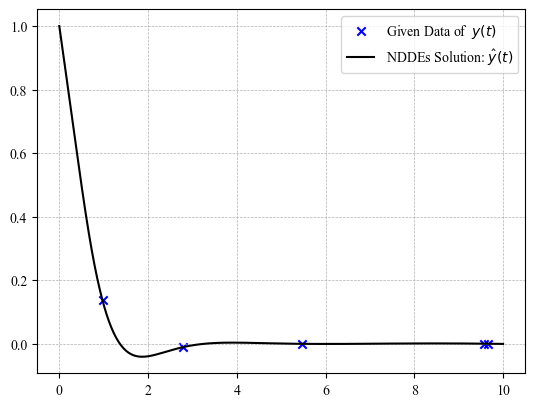

In [144]:
# MATLAB solution
dde_solve_path = os.path.join(config['given_data_root_path'], f"DDE23_ex4.2.1_tau_{lag}.csv")
dde_sol = pd.read_csv(dde_solve_path).to_numpy().reshape(-1, 2)

# Extract time points and real values from the data for three different series
t_points = dde_sol[:, 0]
y_real = dde_sol[:, 1]

# Generate a set of 10,000 evenly spaced time points between tmin and tmax
T = np.linspace(tmin, tmax, 10000).reshape(-1, 1)

# Evaluate the neural network for three sets of parameters to get predictions for each set
nn_sol = DNNs(params, T)

# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot real and predicted values for three series using different styles and colors
plt.scatter(t_points, y_real, label='Given Data of  $y(t)$', color='blue', marker='x')

plt.plot(T, nn_sol, 'k', label='NDDEs Solution: $\hat{y}(t)$')

# Add a legend with font properties
plt.legend(prop=prop)

# Set labels for the x and y axes with font properties
# plt.xlabel('$t$', fontproperties=prop)
# plt.ylabel('$y(t)$', fontproperties=prop)

# Customize the appearance of the axis tick labels using font properties
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Optionally save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"Sol_ex4.2.1_tau_{lag}_noise_level_{config['noise_level']}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()


### Lag

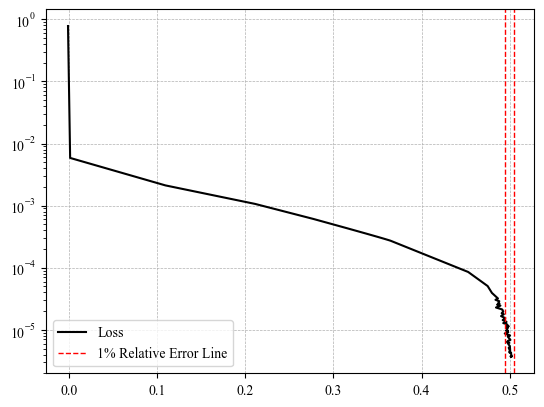

In [145]:
# Define a function to compute relative error bounds
def relative_error_lines(real_value, error_percentage):
    """ Calculate the lower and upper bounds of real_value considering a percentage error. """
    lower_bound = real_value * (1 - error_percentage / 100)
    upper_bound = real_value * (1 + error_percentage / 100)
    return lower_bound, upper_bound, error_percentage

lag_history = jnp.stack(lag_history)

loss_history_tem = loss_history

# Calculate error bounds for the given real_lag with a 3% error margin
lower_bound, upper_bound, error_percentage = relative_error_lines(config['real_lag'], 1)

# Set the figure size in a 4:3 aspect ratio
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot the smoothed loss history
plt.plot(lag_history, loss_history_tem, 'k', label='Loss')

# Draw vertical lines representing the 3% error range
plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=1, label=f'{error_percentage}% Relative Error Line')
plt.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1)

# Set the y-axis to logarithmic scale for better visualization of differences
plt.yscale('log')

# Add labels to the axes
# plt.xlabel(f'$\\tau$', fontproperties=prop)
# plt.ylabel('Loss', fontproperties=prop)

# Customize the tick labels using font properties
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Add grid lines, major only, with specific style
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Display the legend with custom font properties
plt.legend(prop=prop)

# Save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"Lag_ex4.2.1_tau_{lag}_noise_level_{config['noise_level']}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()